<a href="https://colab.research.google.com/github/z0li627/DS-Unit-2-Linear-Models/blob/master/Zoltan_Gaspar_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [46]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,23000,23001,23002,23003,23004,23005,23006,23007,23008,23009,23010,23011,23012,23013,23014,23015,23016,23017,23018,23019,23020,23021,23022,23023,23024,23025,23026,23027,23028,23029,23030,23031,23032,23033,23034,23035,23036,23037,23038,23039
BOROUGH,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
NEIGHBORHOOD,OTHER,OTHER,OTHER,OTHER,UPPER EAST SIDE (59-79),UPPER EAST SIDE (79-96),OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,BOROUGH PARK,OTHER,OTHER,OTHER,OTHER,...,FLUSHING-NORTH,FLUSHING-NORTH,FLUSHING-NORTH,FLUSHING-NORTH,OTHER,FOREST HILLS,FOREST HILLS,FOREST HILLS,FOREST HILLS,FOREST HILLS,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER
BUILDING_CLASS_CATEGORY,13 CONDOS - ELEVATOR APARTMENTS,21 OFFICE BUILDINGS,21 OFFICE BUILDINGS,13 CONDOS - ELEVATOR APARTMENTS,15 CONDOS - 2-10 UNIT RESIDENTIAL,07 RENTALS - WALKUP APARTMENTS,07 RENTALS - WALKUP APARTMENTS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,05 TAX CLASS 1 VACANT LAND,29 COMMERCIAL GARAGES,29 COMMERCIAL GARAGES,29 COMMERCIAL GARAGES,29 COMMERCIAL GARAGES,29 COMMERCIAL GARAGES,32 HOSPITAL AND HEALTH FACILITIES,33 EDUCATIONAL FACILITIES,08 RENTALS - ELEVATOR APARTMENTS,21 OFFICE BUILDINGS,29 COMMERCIAL GARAGES,31 COMMERCIAL VACANT LAND,32 HOSPITAL AND HEALTH FACILITIES,32 HOSPITAL AND HEALTH FACILITIES,32 HOSPITAL AND HEALTH FACILITIES,33 EDUCATIONAL FACILITIES,41 TAX CLASS 4 - OTHER,14 RENTALS - 4-10 UNIT,29 COMMERCIAL GARAGES,31 COMMERCIAL VACANT LAND,31 COMMERCIAL VACANT LAND,03 THREE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,07 RENTALS - WALKUP APARTMENTS,22 STORE BUILDINGS,22 STORE BUILDINGS,22 STORE BUILDINGS,22 STORE BUILDINGS,...,01 ONE FAMILY DWELLINGS,10 COOPS - ELEVATOR APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,10 COOPS - ELEVATOR APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,02 TWO FAMILY DWELLINGS,10 COOPS - ELEVATOR APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,02 TWO FAMILY DWELLINGS,10 COOPS - ELEVATOR APARTMENTS,01 ONE FAMILY DWELLINGS,10 COOPS - ELEVATOR APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,01 ONE FAMILY DWELLINGS,10 COOPS - ELEVATOR APARTMENTS,17 CONDO COOPS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,13 CONDOS - ELEVATOR APARTMENTS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,02 TWO FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,09 COOPS - WALKUP APARTMENTS,10 COOPS - ELEVATOR APARTMENTS,02 TWO FAMILY DWELLINGS,12 CONDOS - WALKUP APARTMENTS
TAX_CLASS_AT_PRESENT,2,4,4,2,2C,2B,2B,1,1,1,1,1B,4,4,4,4,4,4,4,2,4,4,4,4,4,4,4,4,2A,4,4,4,1,1,1,2A,4,4,4,4,...,1,2,2,2,1,1,2,2,2,2,1,2,2,1,2,1,2,2,1,2,2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,2
BLOCK,716,812,839,592,1379,1551,1891,4090,4120,4120,4120,4090,4120,4120,4120,4120,4120,4117,4090,4222,4203,4209,4203,4205,4205,4205,4205,4205,4166,4226,4226,4226,4820,5999,5999,5639,8001,8001,8001,8001,...,5410,4374,5049,5122,6927,3234,2127,2148,2250,2270,3834,3880,3907,10551,10538,13979,11446,1440,10026,3322,3360,13186,8125,16,7623,10745,3104,9412,9430,13215,10162,11612,11808,12295,12536,10965,169,131,8932,1216
LOT,1246,68,69,1041,1402,131,159,37,18,20,19,17,7,8,12,16,17,1,19,84,82,1,81,3,30,55,2,40,4,419,420,422,16,5,22,30,1,4,6,8,...,40,49,19,

In [47]:
df2 = (df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS'])
df2.T

,7,8,9,42,44,48,55,61,63,78,83,108,110,111,119,120,121,122,123,132,136,137,138,139,140,141,150,154,155,156,157,160,161,162,164,165,166,171,172,174,...,22859,22860,22865,22866,22867,22868,22869,22870,22926,22929,22937,22944,22953,22954,22957,22958,22969,22978,22979,22980,22984,22985,22998,22999,23000,23004,23005,23015,23018,23021,23022,23024,23025,23026,23027,23029,23031,23032,23033,23035
BOROUGH,2,2,2,3,3,4,4,4,4,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
NEIGHBORHOOD,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FLUSHING-NORTH,FLUSHING-NORTH,FLUSHING-NORTH,FLUSHING-NORTH,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,BOROUGH PARK,OTHER,EAST NEW YORK,OTHER,OTHER,OTHER,OTHER,OTHER,ASTORIA,OTHER,OTHER,OTHER,OTHER,OTHER,FLUSHING-NORTH,OTHER,FOREST HILLS,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER
BUILDING_CLASS_CATEGORY,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,...,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
BLOCK,4090,4120,4120,6809,5495,7491,2914,7918,12174,4210,5094,5212,7651,7930,6783,6806,6761,8607,5419,7378,1651,2882,5229,5251,5615,7407,10918,10503,13962,14253,1103,3317,9238,12908,2716,2970,11351,9328,9548,13619,...,7748,7832,13694,10193,11926,12576,12596,10968,5867,5052,5481,3573,4025,7801,8939,6938,8408,5272,890,6152,16243,16284,15537,8756,5410,6927,3234,13979,10026,13186,8125,7623,10745,3104,9412,13215,11612,11808,12295,10965
LOT,37,18,20,54,801,24,49,72,26,19,46,69,68,121,35,72,42,85,27,4,22,16,13,66,65,50,33,93,98,1518,57,24,40,45,53,9,49,49,50,18,...,219,79,3,10,92,19,71,78,423,68,73,33,10,10,8,54,55,60,258,48,78,6,54,48,40,5,103,15,33,54,78,38,4,67,48,3,73,50,23,276
EASE-MENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [48]:
df3 = (df2[(df2['SALE_PRICE'] > 100000) & (df2['SALE_PRICE'] < 2000000 )])
df3.T

,44,61,78,108,111,120,121,132,137,141,150,155,156,157,160,162,176,178,180,184,185,186,193,267,282,284,289,296,297,304,312,319,339,343,346,347,349,354,357,360,...,22812,22821,22829,22832,22847,22852,22859,22860,22865,22866,22867,22868,22869,22870,22926,22929,22944,22953,22957,22958,22969,22979,22980,22984,22998,22999,23000,23004,23005,23015,23018,23021,23022,23024,23026,23029,23031,23032,23033,23035
BOROUGH,3,4,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,...,3,4,4,4,4,4,4,4,4,4,4,4,4,4,2,2,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
NEIGHBORHOOD,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FLUSHING-NORTH,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,EAST NEW YORK,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FLUSHING-NORTH,FLUSHING-NORTH,...,OTHER,OTHER,OTHER,FLUSHING-NORTH,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,EAST NEW YORK,OTHER,OTHER,OTHER,ASTORIA,OTHER,OTHER,OTHER,OTHER,FLUSHING-NORTH,OTHER,FOREST HILLS,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER
BUILDING_CLASS_CATEGORY,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,...,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
BLOCK,5495,7918,4210,5212,7930,6806,6761,7378,2882,7407,10918,13962,14253,1103,3317,12908,12352,11936,12985,5708,5442,760,1448,8218,6243,4309,5142,4956,4984,8883,7306,8546,11305,1903,8276,8379,1516,15525,4848,5627,...,8816,7379,8186,5281,10871,12963,7748,7832,13694,10193,11926,12576,12596,10968,5867,5052,3573,4025,8939,6938,8408,890,6152,16243,15537,8756,5410,6927,3234,13979,10026,13186,8125,7623,3104,13215,11612,11808,12295,10965
LOT,801,72,19,69,121,72,42,4,16,50,33,98,1518,57,24,45,463,56,48,35,145,89,1,68,6,36,115,4,68,34,68,47,19,21,600,130,44,13,35,21,...,27,32,1,92,51,333,219,79,3,10,92,19,71,78,423,68,33,10,8,54,55,258,48,78,54,48,40,5,103,15,33,54,78,38,67,3,73,50,23,276
EASE-MENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [49]:
df3['SALE_DATE'].dtypes

dtype('O')

In [50]:
df3['SALE_DATE'] = pd.to_datetime(df3['SALE_DATE'], infer_datetime_format=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
df3['SALE_DATE'].dtypes

dtype('<M8[ns]')

In [52]:
df3.T

,44,61,78,108,111,120,121,132,137,141,150,155,156,157,160,162,176,178,180,184,185,186,193,267,282,284,289,296,297,304,312,319,339,343,346,347,349,354,357,360,...,22812,22821,22829,22832,22847,22852,22859,22860,22865,22866,22867,22868,22869,22870,22926,22929,22944,22953,22957,22958,22969,22979,22980,22984,22998,22999,23000,23004,23005,23015,23018,23021,23022,23024,23026,23029,23031,23032,23033,23035
BOROUGH,3,4,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,...,3,4,4,4,4,4,4,4,4,4,4,4,4,4,2,2,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
NEIGHBORHOOD,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FLUSHING-NORTH,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,EAST NEW YORK,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FLUSHING-NORTH,FLUSHING-NORTH,...,OTHER,OTHER,OTHER,FLUSHING-NORTH,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,EAST NEW YORK,OTHER,OTHER,OTHER,ASTORIA,OTHER,OTHER,OTHER,OTHER,FLUSHING-NORTH,OTHER,FOREST HILLS,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER
BUILDING_CLASS_CATEGORY,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,...,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS,01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
BLOCK,5495,7918,4210,5212,7930,6806,6761,7378,2882,7407,10918,13962,14253,1103,3317,12908,12352,11936,12985,5708,5442,760,1448,8218,6243,4309,5142,4956,4984,8883,7306,8546,11305,1903,8276,8379,1516,15525,4848,5627,...,8816,7379,8186,5281,10871,12963,7748,7832,13694,10193,11926,12576,12596,10968,5867,5052,3573,4025,8939,6938,8408,890,6152,16243,15537,8756,5410,6927,3234,13979,10026,13186,8125,7623,3104,13215,11612,11808,12295,10965
LOT,801,72,19,69,121,72,42,4,16,50,33,98,1518,57,24,45,463,56,48,35,145,89,1,68,6,36,115,4,68,34,68,47,19,21,600,130,44,13,35,21,...,27,32,1,92,51,333,219,79,3,10,92,19,71,78,423,68,33,10,8,54,55,258,48,78,54,48,40,5,103,15,33,54,78,38,67,3,73,50,23,276
EASE-MENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [0]:
df3 = df3.drop('EASE-MENT', 1)
df3 = df3.drop('APARTMENT_NUMBER', 1)
df3 = df3.drop('TAX_CLASS_AT_TIME_OF_SALE', 1)

In [54]:
cutoff = pd.to_datetime('2019-04-01')
train = df3[df3.SALE_DATE < cutoff ]
test = df3[df3.SALE_DATE >= cutoff]
train.shape, test.shape

((2507, 18), (644, 18))

In [55]:
train.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [56]:
train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,2507.0,6758.303949,3975.909029,21.0,3837.5,6022.0,9888.5,16350.0
LOT,2507.0,75.778221,157.531138,1.0,21.0,42.0,70.0,2720.0
ZIP_CODE,2507.0,10993.398484,494.291462,10301.0,10314.0,11234.0,11413.0,11697.0
RESIDENTIAL_UNITS,2507.0,0.987635,0.110532,0.0,1.0,1.0,1.0,1.0
COMMERCIAL_UNITS,2507.0,0.016354,0.129966,0.0,0.0,0.0,0.0,2.0
TOTAL_UNITS,2507.0,1.003989,0.171794,0.0,1.0,1.0,1.0,3.0
GROSS_SQUARE_FEET,2507.0,1473.744715,599.217635,0.0,1144.0,1368.0,1683.0,7875.0
YEAR_BUILT,2507.0,1944.766653,27.059337,1890.0,1925.0,1940.0,1960.0,2018.0
SALE_PRICE,2507.0,621573.742321,291607.225676,104000.0,440500.0,560000.0,750000.0,1955000.0


In [57]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,7,OTHER,2360,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30
LAND_SQUARE_FEET,2507,887,"4,000",234,NaT,NaT
ADDRESS,2507,2497,216-29 114TH ROAD,2,NaT,NaT


In [58]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
NEIGHBORHOOD,,,,,,,,
ASTORIA,11.0,1.001955e+06,365110.014554,232000.0,820250.00,1090000.0,1180000.0,1600000.0
BEDFORD STUYVESANT,8.0,6.215972e+05,366413.760913,189270.0,287500.00,612500.0,860000.0,1128508.0
BOROUGH PARK,12.0,1.008917e+06,340243.284172,600000.0,898250.00,913750.0,988500.0,1850000.0
EAST NEW YORK,22.0,4.171025e+05,148082.271677,210000.0,264616.25,445000.0,498500.0,800000.0
FLUSHING-NORTH,77.0,8.689417e+05,232499.833916,226667.0,770000.00,845000.0,930000.0,1695000.0
FOREST HILLS,17.0,1.210753e+06,392811.007543,640000.0,875000.00,1122000.0,1490000.0,1876000.0
OTHER,2360.0,6.074223e+05,281638.102705,104000.0,437937.50,550000.0,720000.0,1955000.0


In [59]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].mean()

NEIGHBORHOOD
ASTORIA               1.001955e+06
BEDFORD STUYVESANT    6.215972e+05
BOROUGH PARK          1.008917e+06
EAST NEW YORK         4.171025e+05
FLUSHING-NORTH        8.689417e+05
FOREST HILLS          1.210753e+06
OTHER                 6.074223e+05
Name: SALE_PRICE, dtype: float64

In [0]:
target = 'SALE_PRICE'
high_cardi = ['BUILDING_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_PRESENT', 'SALE_DATE', 'LAND_SQUARE_FEET', 'ADDRESS', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BOROUGH']
features = train.columns.drop([target] + high_cardi)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [61]:
X_train.head().T

,44,61,78,108,111
NEIGHBORHOOD,OTHER,OTHER,OTHER,OTHER,OTHER
BLOCK,5495,7918,4210,5212,7930
LOT,801,72,19,69,121
ZIP_CODE,11230,11427,10461,11226,11203
RESIDENTIAL_UNITS,1,1,1,1,1
COMMERCIAL_UNITS,0,0,0,0,0
TOTAL_UNITS,1,1,1,1,1
GROSS_SQUARE_FEET,1325,2001,2043,2680,1872
YEAR_BUILT,1930,1940,1925,1899,1940


In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True, return_df=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [63]:
X_train.head().T

,44,61,78,108,111
NEIGHBORHOOD_OTHER,1.0,1.0,1.0,1.0,1.0
NEIGHBORHOOD_FLUSHING-NORTH,0.0,0.0,0.0,0.0,0.0
NEIGHBORHOOD_EAST NEW YORK,0.0,0.0,0.0,0.0,0.0
NEIGHBORHOOD_BEDFORD STUYVESANT,0.0,0.0,0.0,0.0,0.0
NEIGHBORHOOD_FOREST HILLS,0.0,0.0,0.0,0.0,0.0
NEIGHBORHOOD_BOROUGH PARK,0.0,0.0,0.0,0.0,0.0
NEIGHBORHOOD_ASTORIA,0.0,0.0,0.0,0.0,0.0
BLOCK,5495.0,7918.0,4210.0,5212.0,7930.0
LOT,801.0,72.0,19.0,69.0,121.0
ZIP_CODE,11230.0,11427.0,10461.0,11226.0,11203.0


In [67]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected, X_test_selected

(array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.325e+03,
         1.930e+03],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 2.001e+03,
         1.940e+03],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 2.043e+03,
         1.925e+03],
        ...,
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.807e+03,
         2.018e+03],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 6.210e+02,
         1.930e+03],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.163e+03,
         1.950e+03]]),
 array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 2.272e+03,
         1.930e+03],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 7.200e+02,
         1.935e+03],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 2.210e+03,
         1.925e+03],
        ...,
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.333e+03,
         1.945e+03],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.020e+03,
   

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features
Test Mean Absolute Error: $183,641 

2 features
Test Mean Absolute Error: $184,003 

3 features
Test Mean Absolute Error: $178,255 

4 features
Test Mean Absolute Error: $177,591 

5 features
Test Mean Absolute Error: $176,979 

6 features
Test Mean Absolute Error: $176,941 

7 features
Test Mean Absolute Error: $164,046 

8 features
Test Mean Absolute Error: $164,898 

9 features
Test Mean Absolute Error: $160,633 

10 features
Test Mean Absolute Error: $160,633 

11 features
Test Mean Absolute Error: $161,146 

12 features
Test Mean Absolute Error: $161,146 

13 features
Test Mean Absolute Error: $161,148 

14 features
Test Mean Absolute Error: $160,855 

15 features
Test Mean Absolute Error: $160,855 



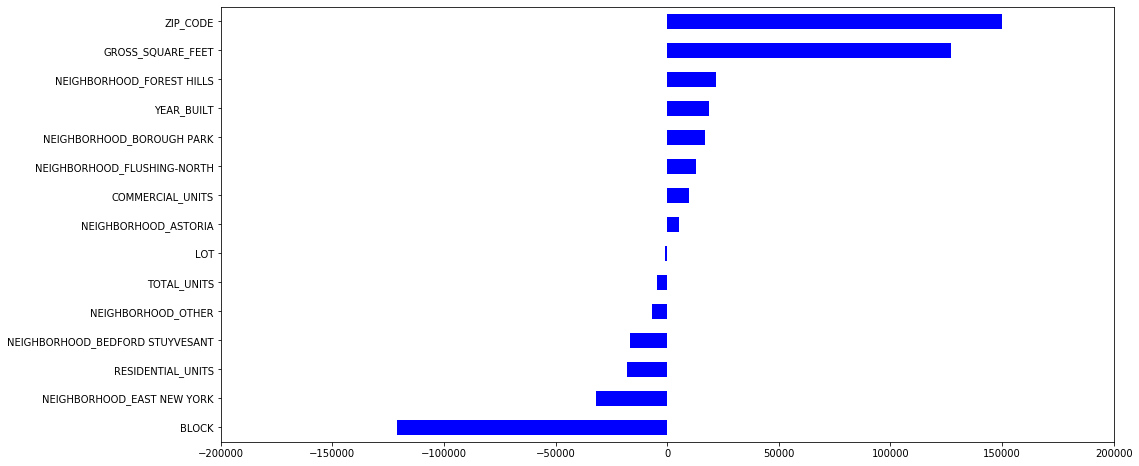

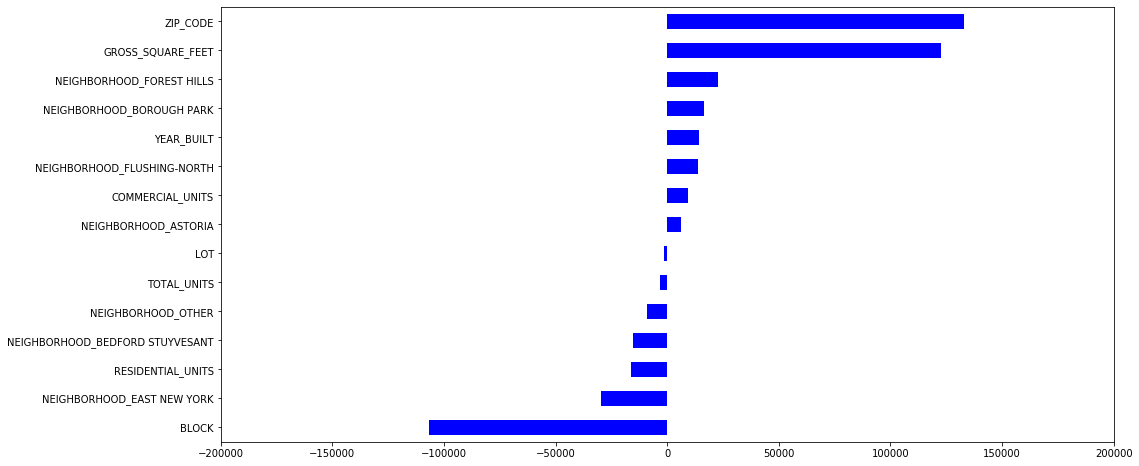

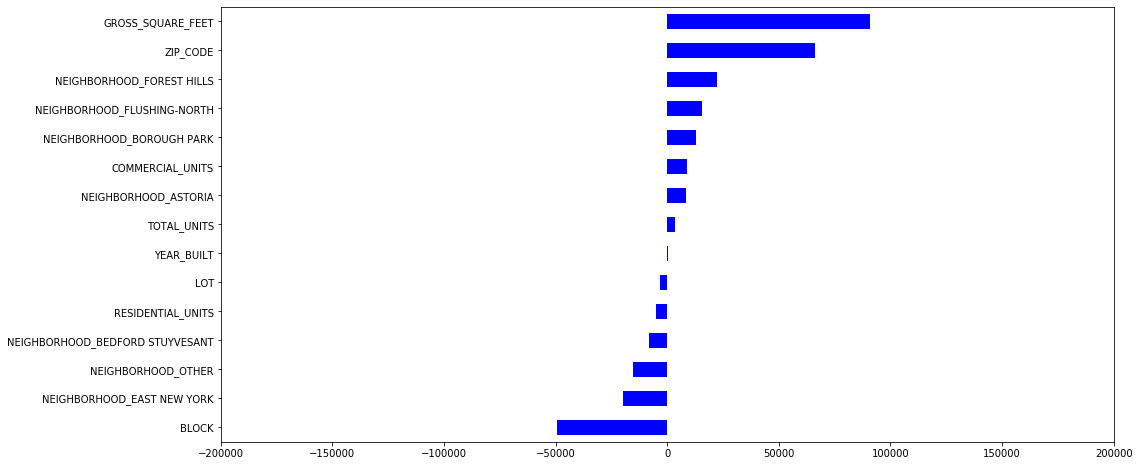

In [88]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

for zeta in [10**1, 10**2, 10**3]:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    display(HTML(f'Ridge Regression, with alpha={zeta}'))
    model = Ridge(alpha=zeta)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_train_scaled)
    trainmae = mean_absolute_error(y_train, y_pred)
    display(HTML(f'Train Mean Absolute Error: ${trainmae:,.0f}'))
    y_pred = model.predict(X_test_scaled)
    testmae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${testmae:,.0f}'))
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='blue')
    plt.xlim(-200000,200000)
    plt.show()

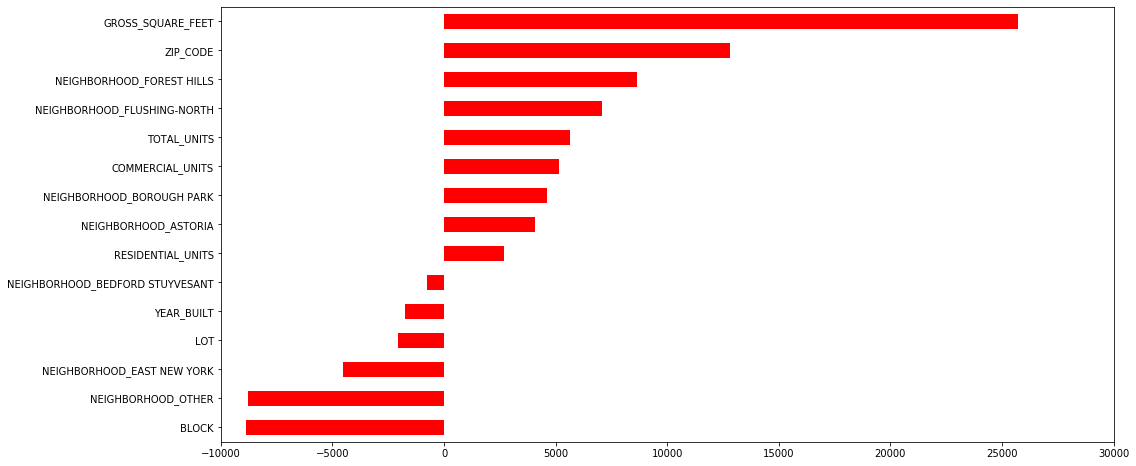

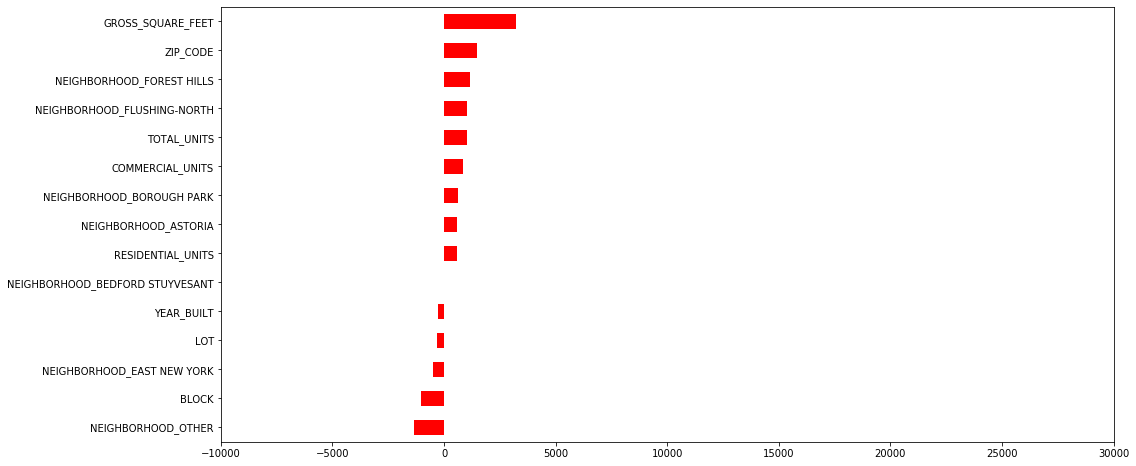

In [86]:
for gamma in [10**4, 10**5]:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    display(HTML(f'Ridge Regression, with alpha={gamma}'))
    model = Ridge(alpha=gamma)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_train_scaled)
    trainmae = mean_absolute_error(y_train, y_pred)
    display(HTML(f'Train Mean Absolute Error: ${trainmae:,.0f}'))
    y_pred = model.predict(X_test_scaled)
    testmae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${testmae:,.0f}'))
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='red')
    plt.xlim(-10000,30000)
    plt.show()

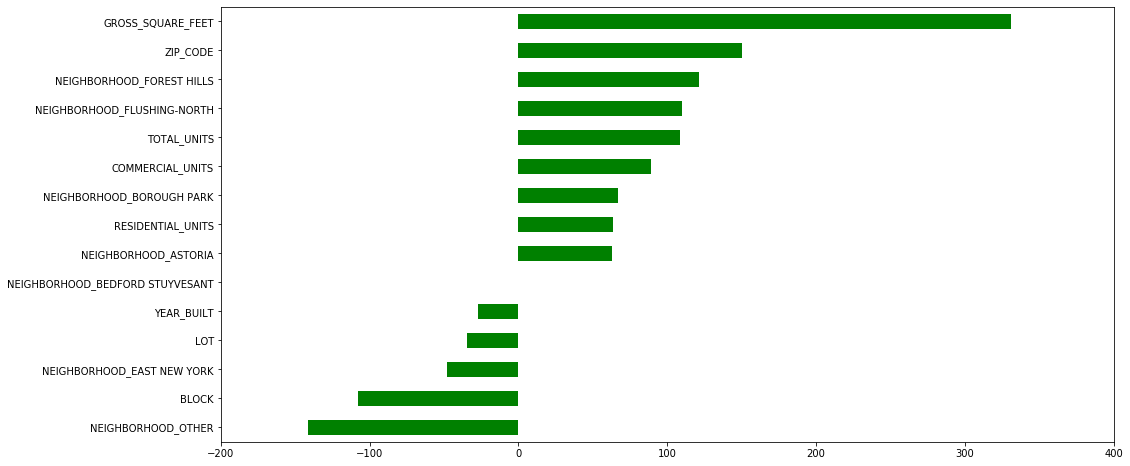

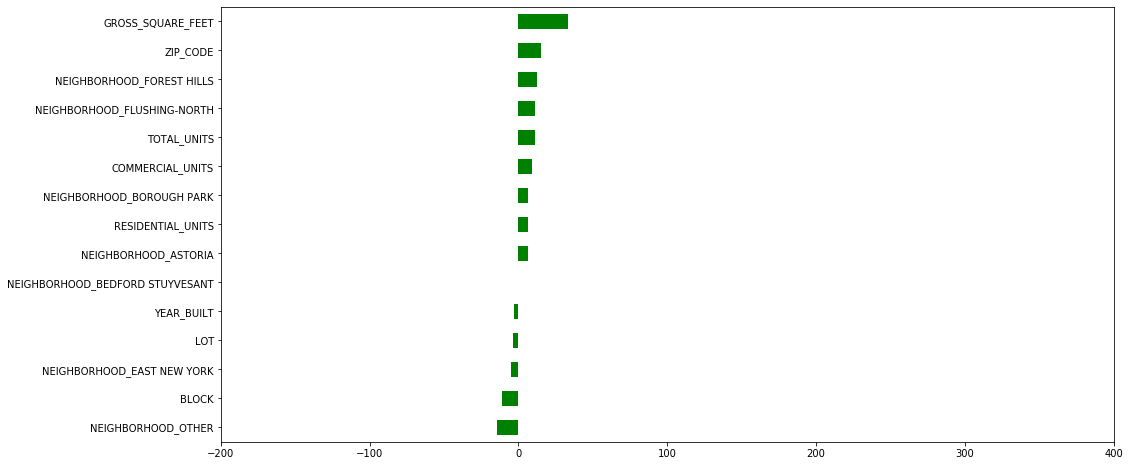

In [87]:
for theta in [10**6, 10**7]:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    display(HTML(f'Ridge Regression, with alpha={theta}'))
    model = Ridge(alpha=theta)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_train_scaled)
    trainmae = mean_absolute_error(y_train, y_pred)
    display(HTML(f'Train Mean Absolute Error: ${trainmae:,.0f}'))
    y_pred = model.predict(X_test_scaled)
    testmae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${testmae:,.0f}'))
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='green')
    plt.xlim(-200,400)
    plt.show()